In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import json
import sklearn
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM,Dropout , Input, GRU
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.optimizers import SGD
import seaborn as sns
from numpy import array
from numpy import asarray
from numpy import zeros
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau ,EarlyStopping, ModelCheckpoint

In [2]:
def load_training_data_to_pandas(filename = 'data/train.jsonl'):
    X = []
    Y = []
    fhand = open(filename,encoding='utf8')
    for line in fhand:
        data = json.loads(line)

        lt = data['context']
        lt.reverse()
        fullTweet =   data['response'] + " " + ''.join(lt)

        X.append(fullTweet)
        Y.append(data['label'])
 
    
    dfdata = pd.DataFrame({'Tweets': X,'Labels': Y}) 

    dfdata.to_csv(r'data/dataPandas.csv',index=False)


In [3]:
def load_test_data_to_pandas(filename = 'data/test.jsonl'):
    tid = []
    X = []
    Y = []
    fhand = open(filename,encoding='utf8')
    for line in fhand:
        data = json.loads(line)
        tid.append(data['id'])
        lt = data['context']
        lt.reverse()
        fullTweet =   data['response'] + " " + ''.join(lt)

        X.append(fullTweet)
        
    
    dftestdata = pd.DataFrame({'ID': tid,
                   'Tweets': X})
    
   
    dftestdata.to_csv(r'data/dftestdata.csv',index=False)


    #return X_train,Y_train,X_test,Y_test,maxLen

In [4]:
load_training_data_to_pandas()
load_test_data_to_pandas()

In [5]:
twitterdata = pd.read_csv("data/dataPandas.csv")
twitterdata.isnull().values.any()
twitterdata.shape

(5000, 2)

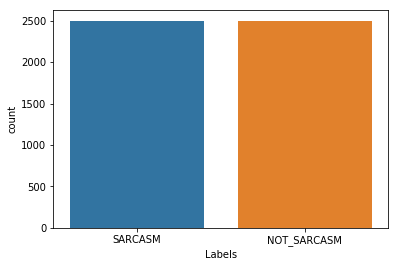

In [6]:
sns.countplot(x='Labels', data=twitterdata)

In [7]:
def preprocess_text(sen):
    # Removing html tags
    sentence = sen.replace('@USER',' ')
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # stemming
    porter = PorterStemmer()
    words = sen.split() 
    stemmed_words = [porter.stem(word) for word in words]
    sentence = " ".join(stemmed_words)
    return sentence

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [9]:
X = []
sentences = list(twitterdata['Tweets'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [114]:
y = twitterdata['Labels']

y = np.array(list(map(lambda x: 1 if x=="SARCASM" else 0, y)))

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,random_state=4)

In [174]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [175]:
embeddings_dictionary = dict()
glove_file = open('./Data/glove.twitter.27B.100d.txt', encoding="utf8")
#glove_file = open('./Data/glove.6B.100d.txt', encoding="utf8")


for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [178]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [97]:
#Neural Network
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          905600    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 10001     
Total params: 915,601
Trainable params: 10,001
Non-trainable params: 905,600
_________________________________________________________________
None


In [215]:
#GRU
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=True)
model.add(embedding_layer)
model.add(GRU(128,dropout=0.5, recurrent_dropout=0.2,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience =2)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
#model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 200, 100)          2263300   
_________________________________________________________________
gru_20 (GRU)                 (None, 200, 128)          88320     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 17        
Total params: 2,353,701
Trainable params: 2,353,701
Non-trainable params: 0
___________________________________________

In [216]:
history = model.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.3, callbacks=[es, mc])

Epoch 1/25
22/22 [==============================] - ETA: 0s - loss: 0.7059 - acc: 0.5061
Epoch 00001: val_acc improved from -inf to 0.63583, saving model to best_model.h5
22/22 [==============================] - 32s 1s/step - loss: 0.7059 - acc: 0.5061 - val_loss: 0.6837 - val_acc: 0.6358
Epoch 2/25
22/22 [==============================] - ETA: 0s - loss: 0.6825 - acc: 0.5446
Epoch 00002: val_acc did not improve from 0.63583
22/22 [==============================] - 34s 2s/step - loss: 0.6825 - acc: 0.5446 - val_loss: 0.6698 - val_acc: 0.6125
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 0.6619 - acc: 0.6025
Epoch 00003: val_acc did not improve from 0.63583
22/22 [==============================] - 34s 2s/step - loss: 0.6619 - acc: 0.6025 - val_loss: 0.6526 - val_acc: 0.6000
Epoch 4/25
22/22 [==============================] - ETA: 0s - loss: 0.6382 - acc: 0.6268
Epoch 00004: val_acc improved from 0.63583 to 0.71333, saving model to best_model.h5
22/22 [=============

In [217]:
from keras.models import load_model
saved_model = load_model('best_model.h5')
score,accuracy = saved_model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 5s 162ms/step - loss: 0.5563 - acc: 0.7230


In [218]:
score,accuracy = saved_model.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 5s 160ms/step - loss: 0.5563 - acc: 0.7230


In [219]:
print("Test Score:", score)
print("Test Accuracy:", accuracy)
y_pred = saved_model.predict(X_test)
y_pred =(y_pred>0.5)
print(len(y_pred))

cm = confusion_matrix(y_test, y_pred)
print (y_test)
print(cm)

Test Score: 0.5562872290611267
Test Accuracy: 0.7229999899864197
1000
[0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0
 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1
 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1
 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1
 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1
 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0
 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0
 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1
 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1
 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0

In [220]:
def myscores(smat): 
    tp = smat[0][0] 
    fp = smat[0][1] 
    fn = smat[1][0] 
    tn = smat[1][1] 
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f1 = (2*p*r)/(p+r)
    return p,r,f1

print(myscores(cm))

(0.604, 0.7926509186351706, 0.6855845629965948)


In [221]:
twittertestdata = pd.read_csv("data/dftestdata.csv")
twittertestdata.isnull().values.any()

False

In [222]:
X_val = []
sentences = list(twittertestdata['Tweets'])
for sen in sentences:
    X_val.append(preprocess_text(sen))
    
X_validate = tokenizer.texts_to_sequences(X_val)
#X_valTokens = tokenizer.texts_to_sequences(X_validate)
X_valTokens = pad_sequences(X_validate, padding='post', maxlen=maxlen)

In [223]:
validation = model.predict(X_valTokens)

In [224]:
twittertestdata['Predict'] = validation

In [225]:
twittertestdata['PLabel'] = np.where(twittertestdata['Predict'] > 0.5, "SARCASM", "NOT_SARCASM")

In [226]:
twittertestdata.head()

,ID,Tweets,Predict,PLabel
0,twitter_1,"@USER @USER @USER My 3 year old , that just fi...",0.886082,SARCASM
1,twitter_2,@USER @USER How many verifiable lies has he to...,0.902439,SARCASM
2,twitter_3,@USER @USER @USER Maybe Docs just a scrub of a...,0.858443,SARCASM
3,twitter_4,@USER @USER is just a cover up for the real ha...,0.828586,SARCASM
4,twitter_5,@USER @USER @USER The irony being that he even...,0.938814,SARCASM


In [227]:
twittertestdata.to_csv('answer_KerasLSTM.txt', columns = ["ID" , "PLabel"] , header = False , index = False)
